# 3.3 미래에 볼 영화의 평점 예측하기
- 평점 예측 기법을 알아보자

## 1. 탐색 : MovieLens 데이터 살펴보기

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
rating_file_path = 'data/ml-1m/ratings.dat'
movie_file_path = 'data/ml-1m/movies.dat'
user_file_path = 'data/ml-1m/users.dat'

rating_data = pd.io.parsers.read_csv(rating_file_path,
                                    names=['user_id', 'movie_id', 'rating', 'time'],
                                    delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path,
                                   names=['movie_id', 'title', 'genre'],
                                   delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path,
                                  names=['user_id', 'gender', 'age', 'occupation', 'zipcode'],
                                  delimiter='::')

In [3]:
print(rating_data.shape)
rating_data.head()

(1000209, 4)


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
 3   time      1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


```
<rating 데이터>
- user_id : 유저 번호  
- movie_id : 영화 번호
- rating : 점수
- time : 데이터 등록 시간
```

In [5]:
print(movie_data.shape)
movie_data.head()

(3883, 3)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


```
<movie 데이터>
- movie_id : 영화 번호
- title : 영화 제목
- genre : 장르
```

In [7]:
print(user_data.shape)
user_data.head()

(6040, 5)


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


```
<user 데이터>
- user_id : 유저 번호
- gender : 성별
- age : 나이
- occupation : 직업 - 개인정보1
- zipcode : 주소 코드 - 개인정보2
```

## 2. 분석 : 탐색적 데이터 분석하기

In [9]:
# 영화의 개수 약 4000여 개 정도
print('total number of movie in data :', len(movie_data['movie_id'].unique()))

total number of movie in data : 3883


In [10]:
# 영화의 연도 정보 추출해서 새로운 feature 생성
movie_data['year'] = movie_data['title'].apply(lambda x:x[-5:-1])
# 연도별 영화 count Top 10 출력
movie_data['year'].value_counts().head(10)

1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [11]:
# 연대별 영화 count
movie_data['year_term'] = movie_data['title'].apply(lambda x:x[-5:-2]+'0')
movie_year_term = movie_data['year_term'].value_counts().sort_index()
print(movie_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


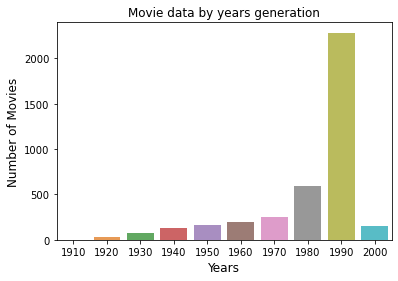

In [12]:
# 연대별 영화 count 시각화
sns.barplot(movie_year_term.index, movie_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

### 장르의 속성 탐색

In [13]:
# 가장 많이 사용된 장르의 조합 Top 10 출력
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

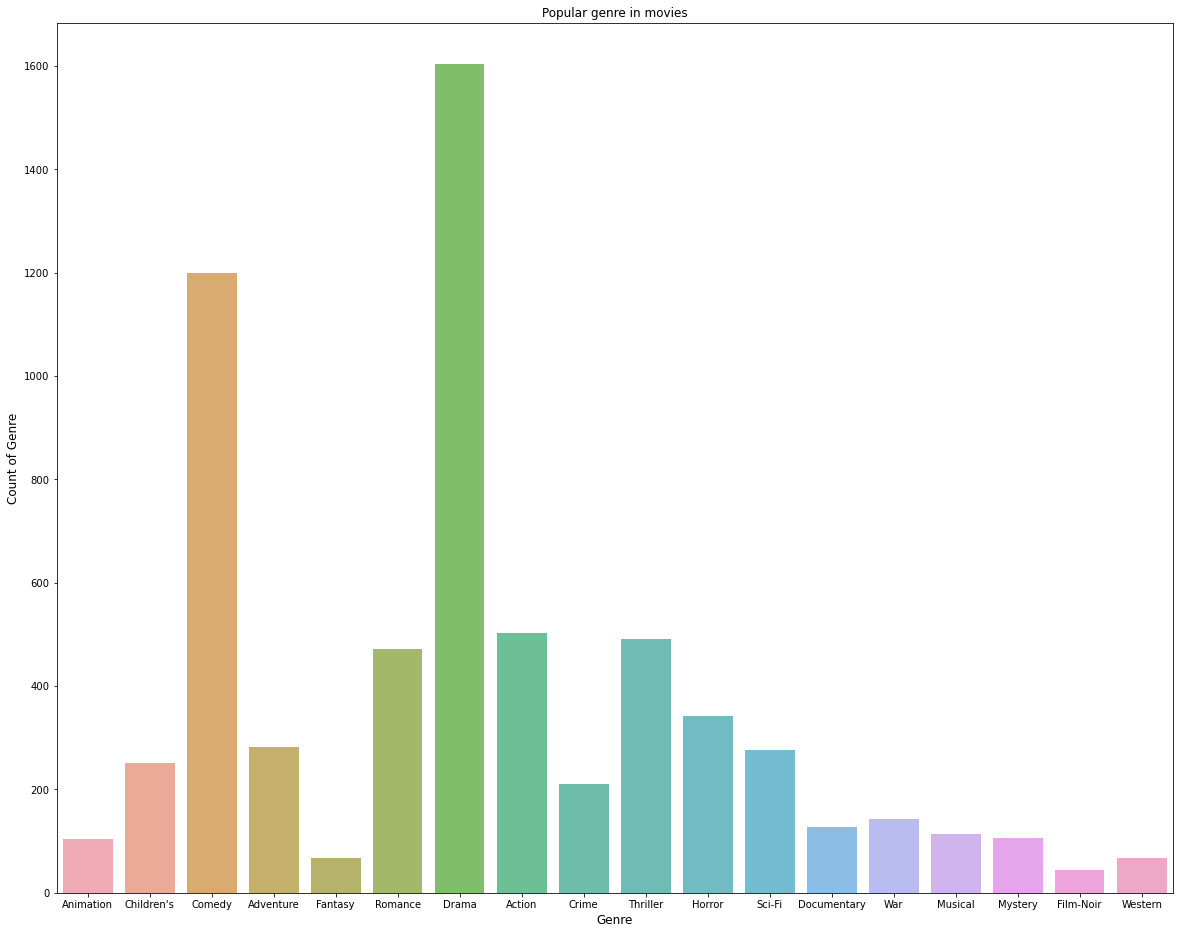

In [14]:
unique_genre_dict = {}

for idx, row in movie_data.iterrows():
    genre_combination = row['genre']
    parsed_genre = genre_combination.split('|')
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

### user 정보 탐색

In [15]:
# 유저의 수
print('total number of user in data :', len(user_data['user_id'].unique()))

total number of user in data : 6040


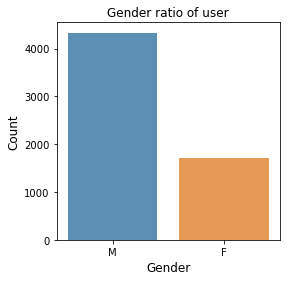

In [16]:
# 유저의 성별
plt.rcParams['figure.figsize'] = [4,4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [17]:
# 유저의 연령대
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [18]:
# 나이 1인 값 제거 & 나이대 전처리
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + '0'

user_data['ages'] = user_data['age'].apply(lambda x:age_classification(x))
user_ages = user_data['ages'].value_counts()
user_ages

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: ages, dtype: int64

<AxesSubplot:ylabel='ages'>

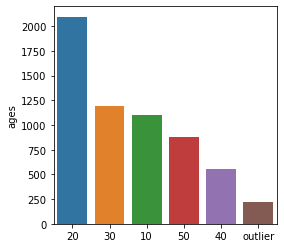

In [19]:
sns.barplot(user_ages.index, user_ages)

- 지금까지는 '평점 예측'의 측면에서는 중요한 탐색이라고 볼 수 없다.

### rating 데이터 정보 탐색

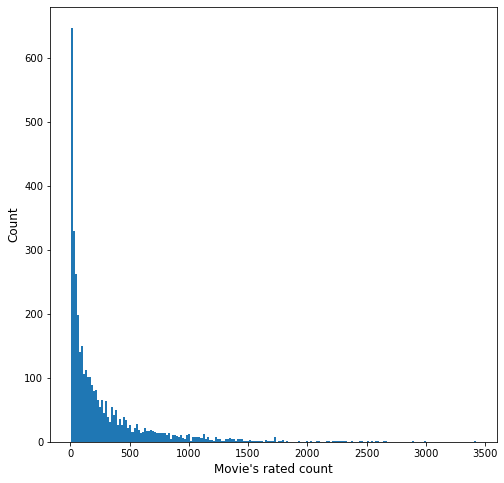

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [20]:
# 각 영화들이 평가받은 횟수
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

print('total number of movie in data :', len(movie_data['movie_id'].unique()))
print('total number of movie rated below 100 :', len(movie_rate_count[movie_rate_count<100]))

In [21]:
# 영화별 평균 평점 탐색
# 각 영화당 rating의 개수와 평균값 계산
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(
    {'count','mean'})
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info.head()

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

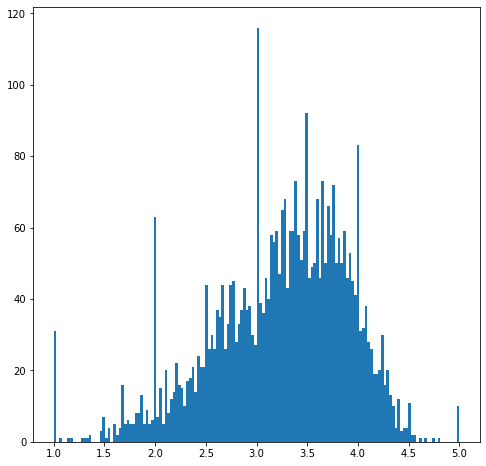

In [22]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

- 대부분의 평점은 2점 - 4점 사이로 나타남  
    => 대부분의 평점은 2점 - 4점 사이의 값으로 예측될 것이라는 가설 수립

In [23]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화 출력
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


In [24]:
# 유저별 영화 평가
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

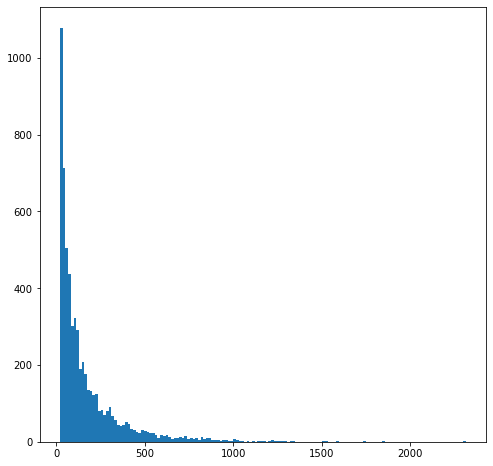

In [25]:
# 유저별로 평가한 영화 개수의 분포
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

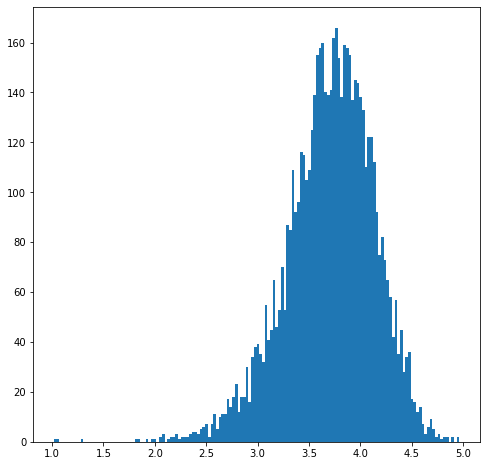

In [26]:
# 유저별로 평가한 영화 점수 평균의 분포 출력
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

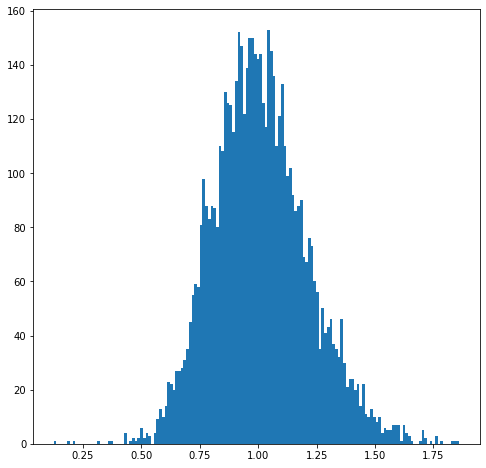

In [27]:
# 유저별로 평가한 영화 점수 편차의 분포 출력
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

### user-movie 형태의 테이블로 살펴보기

- 현재 분석 중인 MovieLens 데이터 : U-I-R(User-Item-Rating) 데이터셋  
    => 이러한 데이터는 __행렬__로 나타내기에 매우 용이

In [28]:
# unstack() 함수로 user_id, movie_id를 축으로하는 데이터 생성
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

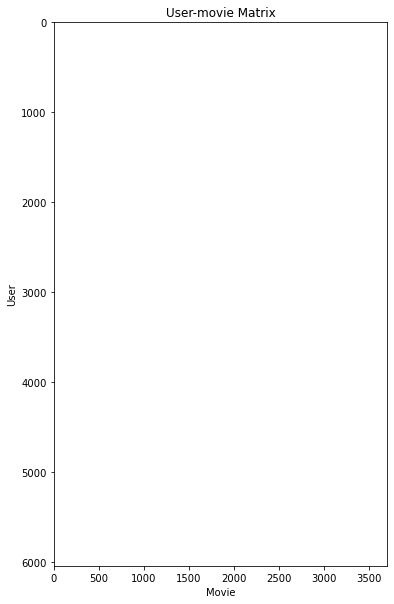

In [29]:
# user-movie table 시각화
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(rating_table, cmap='hot')
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

- 시각화 결과 대부분의 공간에 색이 없는 행렬(희소 행렬)이라는 것을 알 수 있다.
- 이는 대부분의 rating 점수가 아직 채워지지 않았다는 것을 의미한다.
- 비어있는 rating을 채워 넣을 수 있는 가장 대표적인 방법은 행렬의 빈 공간을 채우는 __행렬 완성__ 기법이다.

## 3. 예측 : 수학적 기법을 활용해 평점 예측

- 행렬 완성은 __행렬 분해__ 방법을 이용
- 행렬 분해 : 수학적 성질을 이용하여 하나의 행렬을 여러 개의 행렬 곱으로 나타내는 방법
- 본 예제에서는 행렬 분해 중에서도 가장 활용도가 높은 __특이값 분해(SVD)__라는 방법을 활용하여 영화 평점을 예측할 것이다. 
- SVD란 m*n의 행렬 A를 3개의 행렬 U, S, V로 나누는 것을 의미한다.
- 그리고 이를 반대로 이용하면 3개의 행렬로 원래의 행렬 A를 근사할 수 있다.  

<행렬 완성의 과정>  
1. 3개로 나눠진 행렬 U, S, V의 값을 임의의 숫자로 초기화한다.  
2. 임의의 값으로 채워진 3개의 행렬을 곱하여 새로운 행렬 A'를 계산한다.
3. 새롭게 만들어진 행렬 A'의 값, 그리고 원래의 행렬 A의 값을 비교한다. 
4. 이 값들이 최대한 비슷해지는 값들을 학습한 뒤, 행렬 A'의 빈 공간을 채워 넣는다.

### MovieLens 데이터에 SVD 적용

In [30]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 라이브러리를 사용하기 위한 학습 데이터 생성
reader = Reader(rating_scale=(1, 5)) # 평점의 범위가 1~5인 Reader 객체 생성

# rating 데이터를 surprise 라이브러리의 데이터셋 형태로 변환
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)

model.fit(train_data) # 시간 오래 걸림
train_end = time.time()
print('training time of model : %.2f seconds' %(train_end - train_start))

training time of model : 104.84 seconds


### 학습한 모델의 평점 예측 결과 확인

In [31]:
# user_id = 4인 유저의 영화 평가 데이터
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head()

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [32]:
# user_id = 4인 유저가 평가한 영화 히스토리 정보 추출
target_user_movie_rating_dict = {}

for idx, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
    
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [33]:
# 타겟 유저(user_id = 4)가 보지 않은 영화 정보를 test data로 생성
test_data = []
for idx, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue # 바로 다음 순번의 loop를 수행
    test_data.append((target_user_id, movie_id, rating))
test_data[:10]

[(4, 1, 0),
 (4, 2, 0),
 (4, 3, 0),
 (4, 4, 0),
 (4, 5, 0),
 (4, 6, 0),
 (4, 7, 0),
 (4, 8, 0),
 (4, 9, 0),
 (4, 10, 0)]

In [34]:
# 타겟 유저의 평점 점수를 예측
target_user_predictions = model.test(test_data)

In [35]:
# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장
def get_user_predicted_rating(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid : # target user_id
            if mid not in user_history: # 본 적 없는 영화
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_rating(predictions=target_user_predictions,
                                                          user_id=target_user_id,
                                                          user_history=target_user_movie_rating_dict)

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                    key=operator.itemgetter(1), reverse=True)[:10]
target_user_top10_predicted

[(527, 5),
 (602, 5),
 (615, 5),
 (669, 5),
 (670, 5),
 (750, 5),
 (800, 5),
 (858, 5),
 (898, 5),
 (904, 5)]

In [36]:
# movie_id마다 movie_title을 딕셔너리 형태로 저장
movie_dict = {}
for idx, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title
    
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ':', predicted_rating)

Schindler's List (1993) : 5
Great Day in Harlem, A (1994) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
World of Apu, The (Apur Sansar) (1959) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Lone Star (1996) : 5
Godfather, The (1972) : 5
Philadelphia Story, The (1940) : 5
Rear Window (1954) : 5


## 4. 평가 : 예측 모델 평가

- 행렬 완성의 가장 보편적인 평가 방법은 RMSE를 계산하는 것

In [37]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델 학습
train_start = time.time()
model = SVD(n_factors=8,
           lr_all=0.005,
           reg_all=0.02,
           n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# test data의 RMSE 출력
print('RMSE of test dataset in SVD model :')
accuracy.rmse(predictions)

training time of model: 95.23 seconds
RMSE of test dataset in SVD model :
RMSE: 0.8583


0.8583068769788906

### 시각화

- 4번 user가 영화를 아직 보지 않았다는 가정하에 실제로 보았던 21개 영화의 가상 예측 평점을 계산

In [38]:
# 타겟 유저 정보를 test data로 생성
test_data = []
for idx, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict: # 4번 user가 이미 본 영화
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))
        
# 타겟 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict
            
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화 선정
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions,
                                                           user_id=target_user_id,
                                                           user_history=target_user_movie_rating_dict)
target_user_movie_predict_dict

{260: 4.146873958696046,
 480: 3.3213963340264008,
 1036: 3.853849031726303,
 1097: 4.460421771053079,
 1196: 3.8260934840397463,
 1198: 4.333167780827413,
 1201: 4.378939187923847,
 1210: 3.5291691778183965,
 1214: 4.01741571301739,
 1240: 3.8971395056551894,
 1387: 4.521367696679313,
 1954: 4.47258979124261,
 2028: 4.728455776976972,
 2366: 4.057971747126925,
 2692: 4.046770386489466,
 2947: 4.388423624288531,
 2951: 4.253522680295922,
 3418: 4.145477469060785,
 3468: 4.9276600799350145,
 3527: 3.212591729418025,
 3702: 3.6462917185031305}

- 4번 user가 실제로 관람했던 21개 영화에 대한 가상 예측 평점, 실제 평점, 영화 제목 출력

In [39]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0

for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx += 1
    predicted_rating = round(predicted_rating, 2) # 예측 평점
    origin_rating = target_user_movie_rating_dict[movie_id] # 실제 평점
    movie_title = movie_dict[movie_id]
    print('movie', str(idx), ':', movie_title, '-', origin_rating, '/', predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.15
movie 2 : Jurassic Park (1993) - 4 / 3.32
movie 3 : Die Hard (1988) - 4 / 3.85
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.46
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.83
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.33
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.38
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.53
movie 9 : Alien (1979) - 4 / 4.02
movie 10 : Terminator, The (1984) - 5 / 3.9
movie 11 : Jaws (1975) - 5 / 4.52
movie 12 : Rocky (1976) - 5 / 4.47
movie 13 : Saving Private Ryan (1998) - 5 / 4.73
movie 14 : King Kong (1933) - 4 / 4.06
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.05
movie 16 : Goldfinger (1964) - 5 / 4.39
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.25
movie 18 : Thelma & Louise (1991) - 4 / 4.15
movie 19 : Hustler, The (1961) - 5 / 4.93
movie 20 : Predator (1987) - 1 / 3.21
movie 21 : Mad Max (1979) - 4 / 3.65


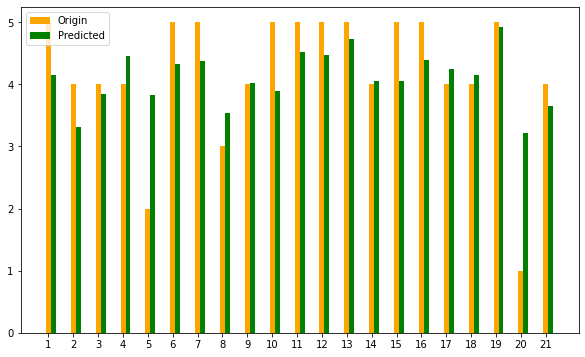

In [40]:
# 실제 점수와 예측 점수를 리스트로 추출
origin = origin_rating_list
predicted = predicted_rating_list

# 영화의 개수만큼 막대 그래프의 index 개수를 생성
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2

# 실제 점수와 예측 점수를 bar 그래프로 출력
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')

rects2 = plt.bar(index+bar_width, predicted, bar_width,
                color='green',
                label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

- 약 1~2개 정도의 영화를 제외하면 실제 평점과 가상 예측 평점이 크게 다르지 않음